In [1]:
# IMPORTING LIBRARIES
import pandas as pd
from datetime import datetime, timedelta
import pickle

import matplotlib.pyplot as plt
import seaborn as sns                                   # For pretty plot
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In this notebook, we train different regressors to relate measurements to the *power* produced by the solar plant at EPFL, in the ELL building. <br>
We start by looking only at the *irradiance* measured in the same building. <br>
From these measurements, we obtain two baseline linear models. <br>
We then pick the most accurate of them, and train regressors with different polynomial expansions.
From these models, we save the most accurate one as `model.p`. <br>
After that, we introduce *temperature* and *wind* measurements (based on the measurements from other weather stations, according to the steps shown in the `geocoding module`) and train more sophisticated regressors.
The final, most accurate model is stored as `model_with_temp_wind.p`.

# Load ELL data

We start by loading data we have collected from ELL.

In [2]:
power = pd.read_csv('ELL data/power.csv', sep=';', parse_dates=['time'])
irrad = pd.read_csv('ELL data/irradiance.csv', sep=';', parse_dates=['time'])

In [3]:
power.head()

,time,power
0,2016-01-01 01:00:00,null
1,2016-01-01 01:01:00,null
2,2016-01-01 01:02:00,null
3,2016-01-01 01:03:00,null
4,2016-01-01 01:04:00,null


In [4]:
irrad.tail()

,time,irradiance
274795,2016-07-09 20:55:00,0.4530000000000001
274796,2016-07-09 20:56:00,0.4520000000000001
274797,2016-07-09 20:57:00,0.4511666666666667
274798,2016-07-09 20:58:00,0.4545000000000002
274799,2016-07-09 20:59:00,0.4577966101694915


We can immediately see that different values are missing from the measurements.

# Handling null values

We firstly need to check how many missing values are present in the collected data.
So, we make a copy of the original DataFrames and we set values in the measurements column to one if the value is missing, 0 otherwise.

In [5]:
whereis_null_power = power.copy()
whereis_null_power.loc[whereis_null_power.power != 'null', 'power'] = 0
whereis_null_power.loc[whereis_null_power.power == 'null', 'power'] = 1

In [6]:
whereis_null_power['power'].value_counts()

0    261641
1     13159
Name: power, dtype: int64

In [7]:
whereis_null_irrad = irrad.copy()
whereis_null_irrad.loc[whereis_null_irrad.irradiance != 'null', 'irradiance'] = 0
whereis_null_irrad.loc[whereis_null_irrad.irradiance == 'null', 'irradiance'] = 1

In [8]:
whereis_null_irrad['irradiance'].value_counts()

0    261641
1     13159
Name: irradiance, dtype: int64

Thus, only 5% of the measurements are missing.
We try two strategies:
- replaing missing values with 0
- removing measurements having missing values

## Replacing null values with zeros

In [9]:
power.replace(to_replace='null', value=0, inplace=True)
irrad.replace(to_replace='null', value=0, inplace=True)

### Data wrangling

Firstly, we convert measurements' values from string to float.

In [10]:
power['power'] = power['power'].astype(float)
irrad['irradiance'] = irrad['irradiance'].astype(float)

In [11]:
power.head()

,time,power
0,2016-01-01 01:00:00,0.0
1,2016-01-01 01:01:00,0.0
2,2016-01-01 01:02:00,0.0
3,2016-01-01 01:03:00,0.0
4,2016-01-01 01:04:00,0.0


Secondly, we add a timestamp to each measurement as the difference, in seconds, from the first measurement.

In [12]:
def get_timestamp_from_time(measurement_datetime, reference_datetime=datetime(2016, 1, 1, 1, 0, 0)):
    """
    Retrieve the difference in time between measurement_time and reference_time.
    :param measurement_datetime: pandas.tslib.Timestamp value of a measurement
    :param reference_datetime: reference datetime value (Default: 01/01/2016 1:00am)
    :return: difference in seconds between measurement_datetime and reference_datetime
    """
    
    return (measurement_datetime - reference_datetime) // timedelta(seconds=1)

In [13]:
seconds = power['time'].apply(get_timestamp_from_time)

In [14]:
power['timestamp'] = seconds
irrad['timestamp'] = seconds

In [15]:
power.head()

,time,power,timestamp
0,2016-01-01 01:00:00,0.0,0
1,2016-01-01 01:01:00,0.0,60
2,2016-01-01 01:02:00,0.0,120
3,2016-01-01 01:03:00,0.0,180
4,2016-01-01 01:04:00,0.0,240


### Plotting power and irradiance distributions 

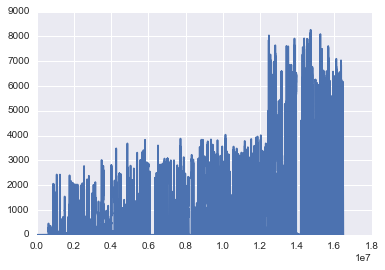

In [16]:
plt.plot(power['timestamp'], power['power'])

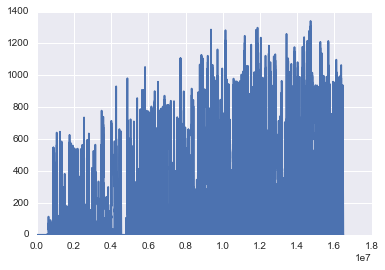

In [17]:
plt.plot(irrad['timestamp'], irrad['irradiance'])

Here, we can see how the total power measured by the solar plant suddenly increases almost at the end of the period we consider.
This is because the number of panels doubled on May 24, 2016!

We need to take this into account in order to learn a correct model. Thus, what we do, is simply dividing the power produced after May 24 by 2.

In [18]:
new_panels_date = datetime(2016,5,24,7,31,0)

We compute the timestamp corresponding to the new installation.

In [19]:
ts_double_panels = get_timestamp_from_time(new_panels_date)

And we identify all those measurements that are affected.

In [20]:
indx = power[power.timestamp >= ts_double_panels].index

Finally, we divide the power by 2 to take into account the doubled number of panels.

In [21]:
y = power.loc[power.timestamp >= ts_double_panels]['power'] / 2
y.head()

207751    0.0
207752    0.0
207753    0.0
207754    0.0
207755    0.0
Name: power, dtype: float64

In [22]:
power.ix[power.timestamp >= ts_double_panels, 'power'] = y

In [23]:
power.loc[indx].tail()

,time,power,timestamp
274795,2016-07-09 20:55:00,0.005,16487700
274796,2016-07-09 20:56:00,0.005,16487760
274797,2016-07-09 20:57:00,0.005,16487820
274798,2016-07-09 20:58:00,0.005,16487880
274799,2016-07-09 20:59:00,0.005,16487940


On the other hand, irradiance is measured in $W/m^2$ and thus there is no need to modify this data.

### Predicting future values with Linear Regression

We now train regressors to relate irradiance measurements to these power measurements.

In [24]:
from sklearn import linear_model

In [25]:
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict

In [26]:
Pdc = power['power'] # y
Gmi = irrad['irradiance'] # X

We start with linear regression.

In [27]:
lin_reg = linear_model.LinearRegression()

And we assess its performances with 10-fold cross validation.

In [28]:
scores = cross_val_score(lin_reg, Gmi.reshape(-1,1), Pdc, cv=10, n_jobs=-1)

In [29]:
print(scores.mean())

0.891767867152


We can then use this model to actually predict new values.

In [30]:
lin_reg.fit(Gmi.reshape(-1,1), Pdc)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [31]:
lin_reg.predict(1)

array([ 13.12858174])

Finally, we show the learnt models in a plot.

In [32]:
predicted = cross_val_predict(lin_reg, Gmi.reshape(-1,1), Pdc, cv=10, n_jobs=-1)

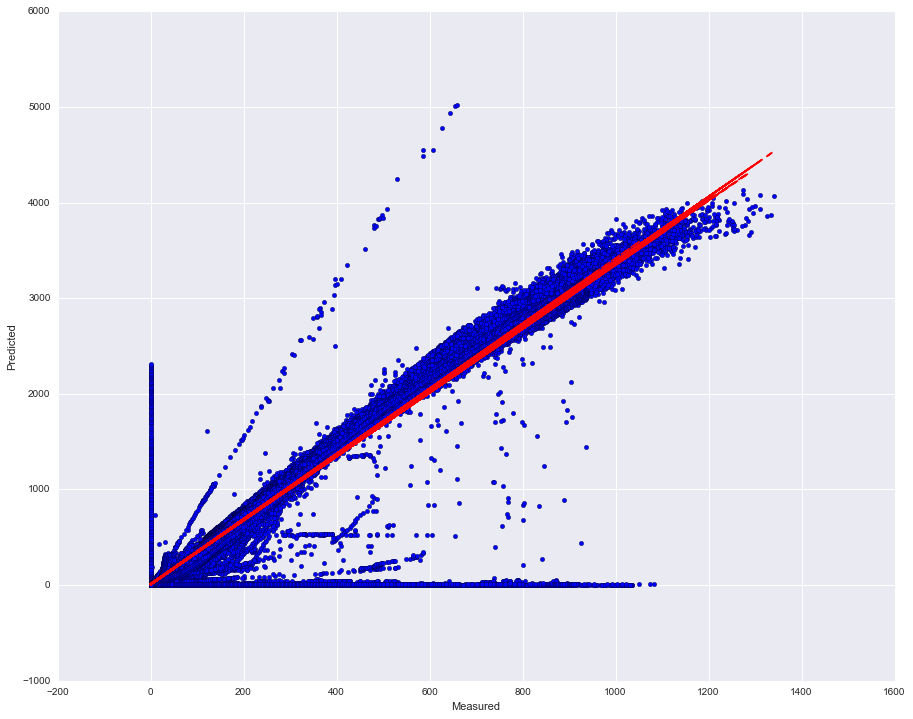

In [33]:
fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(Gmi, Pdc)
ax.plot(Gmi, predicted,'r--')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

## Removing null values

Instead of setting null values to 0, we remove the few measurements having missing values.

In [34]:
power2 = pd.read_csv('ELL data/power.csv', sep=';', parse_dates=['time'])
irrad2 = pd.read_csv('ELL data/irradiance.csv', sep=';', parse_dates=['time'])

In [35]:
power2 = power2[power2.power != 'null']
irrad2 = irrad2[irrad2.irradiance != 'null']

We set measurements to be float (instead of string) and compute timestamps as before.

In [36]:
power2['power'] = power2['power'].astype(float)
irrad2['irradiance'] = irrad2['irradiance'].astype(float)

In [37]:
seconds = power2['time'].apply(get_timestamp_from_time)
power2['timestamp'] = seconds
irrad2['timestamp'] = seconds

And we divide by 2 the power after the number of panels doubled.

In [38]:
new_panels_date = datetime(2016,5,24,7,31,0)
ts_double_panels = get_timestamp_from_time(new_panels_date)
indx2 = power2[power2.timestamp >= ts_double_panels].index
y2 = power2.loc[power2.timestamp >= ts_double_panels]['power'] / 2
power2.ix[power2.timestamp >= ts_double_panels, 'power'] = y2

In [39]:
power2.loc[indx2].tail()

,time,power,timestamp
274795,2016-07-09 20:55:00,0.005,16487700
274796,2016-07-09 20:56:00,0.005,16487760
274797,2016-07-09 20:57:00,0.005,16487820
274798,2016-07-09 20:58:00,0.005,16487880
274799,2016-07-09 20:59:00,0.005,16487940


### Predicting future values with Linear Regression

We train again a linear regressor in order to then compare the performances of the two models.

In [40]:
Pdc2 = power2['power'] # y
Gmi2 = irrad2['irradiance'] # X

In [41]:
lin_reg2 = linear_model.LinearRegression()

In [42]:
scores2 = cross_val_score(lin_reg2, Gmi2.reshape(-1,1), Pdc2, cv=10, n_jobs=-1)

In [43]:
print(scores2.mean())

0.91654976492


Thus, by dropping null values, mean accuracy actually increases!

The predicted models are shown below.

In [44]:
predicted2 = cross_val_predict(lin_reg2, Gmi2.reshape(-1,1), Pdc2, cv=10, n_jobs=-1)

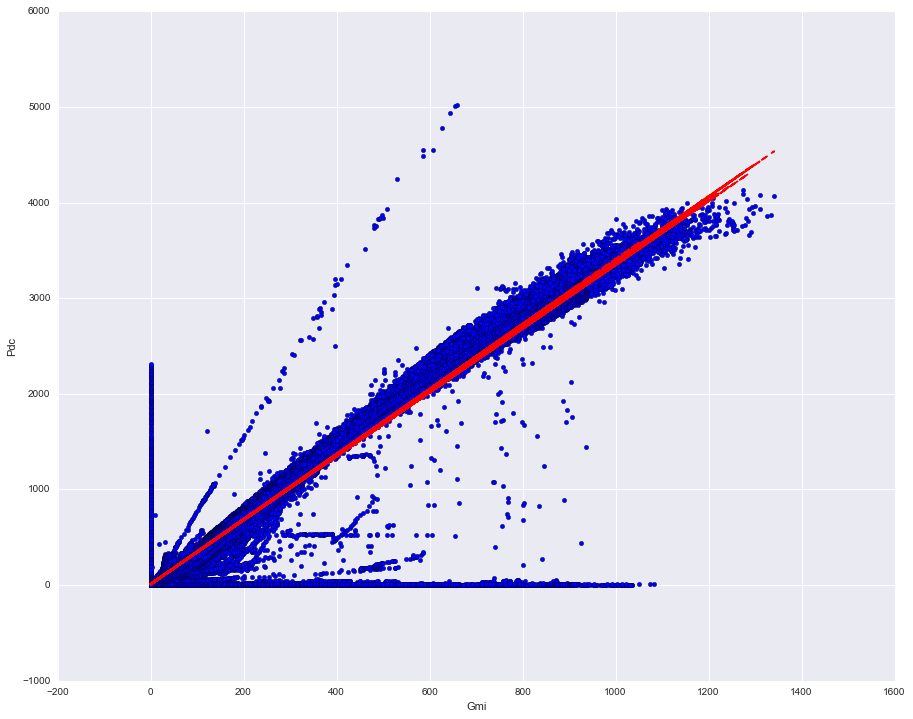

In [45]:
fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(Gmi2, Pdc2)
ax.plot(Gmi2, predicted2,'r--')
ax.set_xlabel('Gmi')
ax.set_ylabel('Pdc')
plt.show()

# Other regression models

We now look at more advanced models to increase the accuracy of the predicted values.

## Polynomial interpolation

We first look at polynomial models, that is, we use different powers of irradiance as features of the model:
$$[1, x^1, x^2, ..., x^{degree}]$$
Where x is each column of the matrix X. In this case, just irradiation

In [46]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

We start by looking at the models for degrees 3, 4 and 5.

In [47]:
colors = ['red', 'yellowgreen', 'gold']

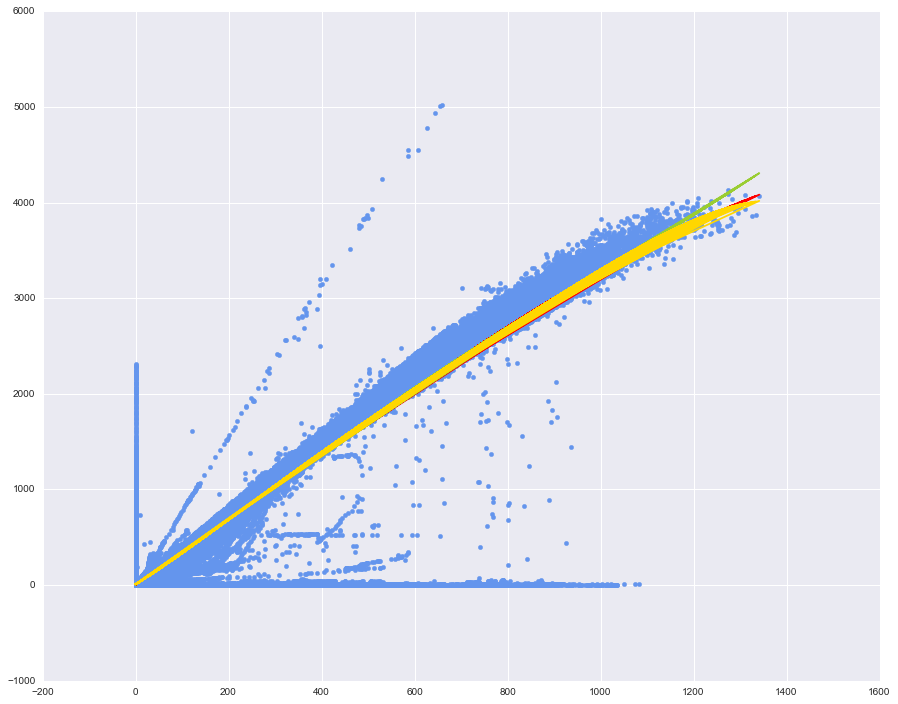

In [48]:
fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(Gmi2, Pdc2, color='cornflowerblue', label="ground truth")
for count, degree in enumerate([3, 4, 5]):
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(Gmi2.reshape(-1,1), Pdc2)
    y_plot = model.predict(Gmi2.reshape(-1,1))
    plt.plot(Gmi2, y_plot, color=colors[count], label="degree %d" % degree)


And we now evaluate the accuracy for different degrees.

In [49]:
for degree in range(1,11):
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    print(degree, '\t', cross_val_score(model, Gmi2.reshape(-1,1), Pdc2, cv=10, n_jobs=-1).mean())

1 	 0.916549764919
2 	 0.916753021399
3 	 0.916559022876
4 	 0.9165506641
5 	 0.916468191573
6 	 0.91649866604
7 	 0.916385608189
8 	 0.916334017856
9 	 0.916231170135
10 	 0.916129699568


Thus, degree 2 gives the best accuracy and we save this model as the best one using irradiance only.
This result seems correct since it resembles the typical logarithmic curve of the performances of any electronic device.

In [50]:
model = make_pipeline(PolynomialFeatures(2), Ridge())
model.fit(Gmi2.reshape(-1,1), Pdc2)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [51]:
pickle.dump(model, open('model.p', 'wb'))

# Load temperature and wind measurements

We load temperature and wind measurements for the ELL building, obtained as described in the `geocoding module`.

In [52]:
tempWind = pickle.load(open("ELL data/ELL_temp_wind_df.p","rb"))
tempWind.head()

,Temp,Wind
2016-01-01 01:00:00,7.30,0.0
2016-01-01 01:01:00,7.32,0.0
2016-01-01 01:02:00,7.34,0.0
2016-01-01 01:03:00,7.36,0.0
2016-01-01 01:04:00,7.38,0.0


We add timestamp for each such measurement.

In [53]:
seconds = power2['time'].apply(get_timestamp_from_time)
tempWind['timestamp'] = seconds

## Predicting future values

And we define a new DataFrame of features for our regression objective.

In [54]:
tempWind.reset_index(inplace=True)

features_df = pd.concat([Gmi2, tempWind],axis = 1, join='inner')
features_df = features_df.drop(['index', 'timestamp'], axis=1)

features_df.head()

,irradiance,Temp,Wind
9519,5.380000,5.78,1.92
9520,5.558833,5.80,1.60
9521,5.683167,5.84,1.60
9522,5.636500,5.88,1.60
9523,5.444833,5.92,1.60


### Linear Regression

In [55]:
X = features_df.values

In [56]:
lin_reg3 = linear_model.LinearRegression()

In [57]:
scores3 = cross_val_score(lin_reg3, X, Pdc2, cv=10, n_jobs=-1)
print(scores3.mean())

0.914915868773


Thus, we notice that linear regression using only irradiance and removing missing values actually performed better than these three features combined.

## Polynomial interpolation

We now look at Kernelized Ridge Regression and assess the performances of the models obtained for different degrees.

In [58]:
for degree in range(1,6):
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    print(degree, '\t', cross_val_score(model, X, Pdc2, cv=10, n_jobs=-1).mean())

1 	 0.914915869093
2 	 0.910482373667
3 	 0.90452096678
4 	 0.899605113148
5 	 0.881250599311


Thus, for these features, the most accurate model is a linear one.

In [59]:
model = make_pipeline(PolynomialFeatures(1), Ridge())
model.fit(X, Pdc2)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [60]:
pickle.dump(model, open('model_with_temp_wind.p', 'wb'))

At the end, polynomial interpolation using only irradiance (`model.p`) gives the best accuracy among the all the models we have investigated.